In [1]:
cd ..

C:\Users\josie\code\PermafrostBankErosionModel


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

from src import permabankerosionmodel, boundaryconditionstools, watertemperaturemodel

# Permafrost Bank Erosion Model Demonstration
Josie Arcuri
9/29/2025

*This notebook decribes the methods developed for "River ice controls permafrost bank erosion in an Arctic delta" by Arcuri et al. (2025)*.

## Description

Permafrost rivers in the Arcic can rapidly erode river banks by melting interstitial pore ice(Costard et al., 2003), entraining thawed sediment (Douglas and Lamb 2024), triggering collapse of the upper river bank (Barnhart et al. (2013)). River bank erosion in Arctic deltas is driven by many environmental factors, including bank ice content,  river bank inundation , river water temperature. However, Arctic delyta in the Arctic Costal Plain of Alska are occupied by river ice for at least 6 months each year. Below, I demonstrate how to use a permafrost bank erosion model that we developed to simulate erosion of a bak profiles over years of time. We use this model to explore how river ice impacts bank erosion in the Canning River delta, AK.


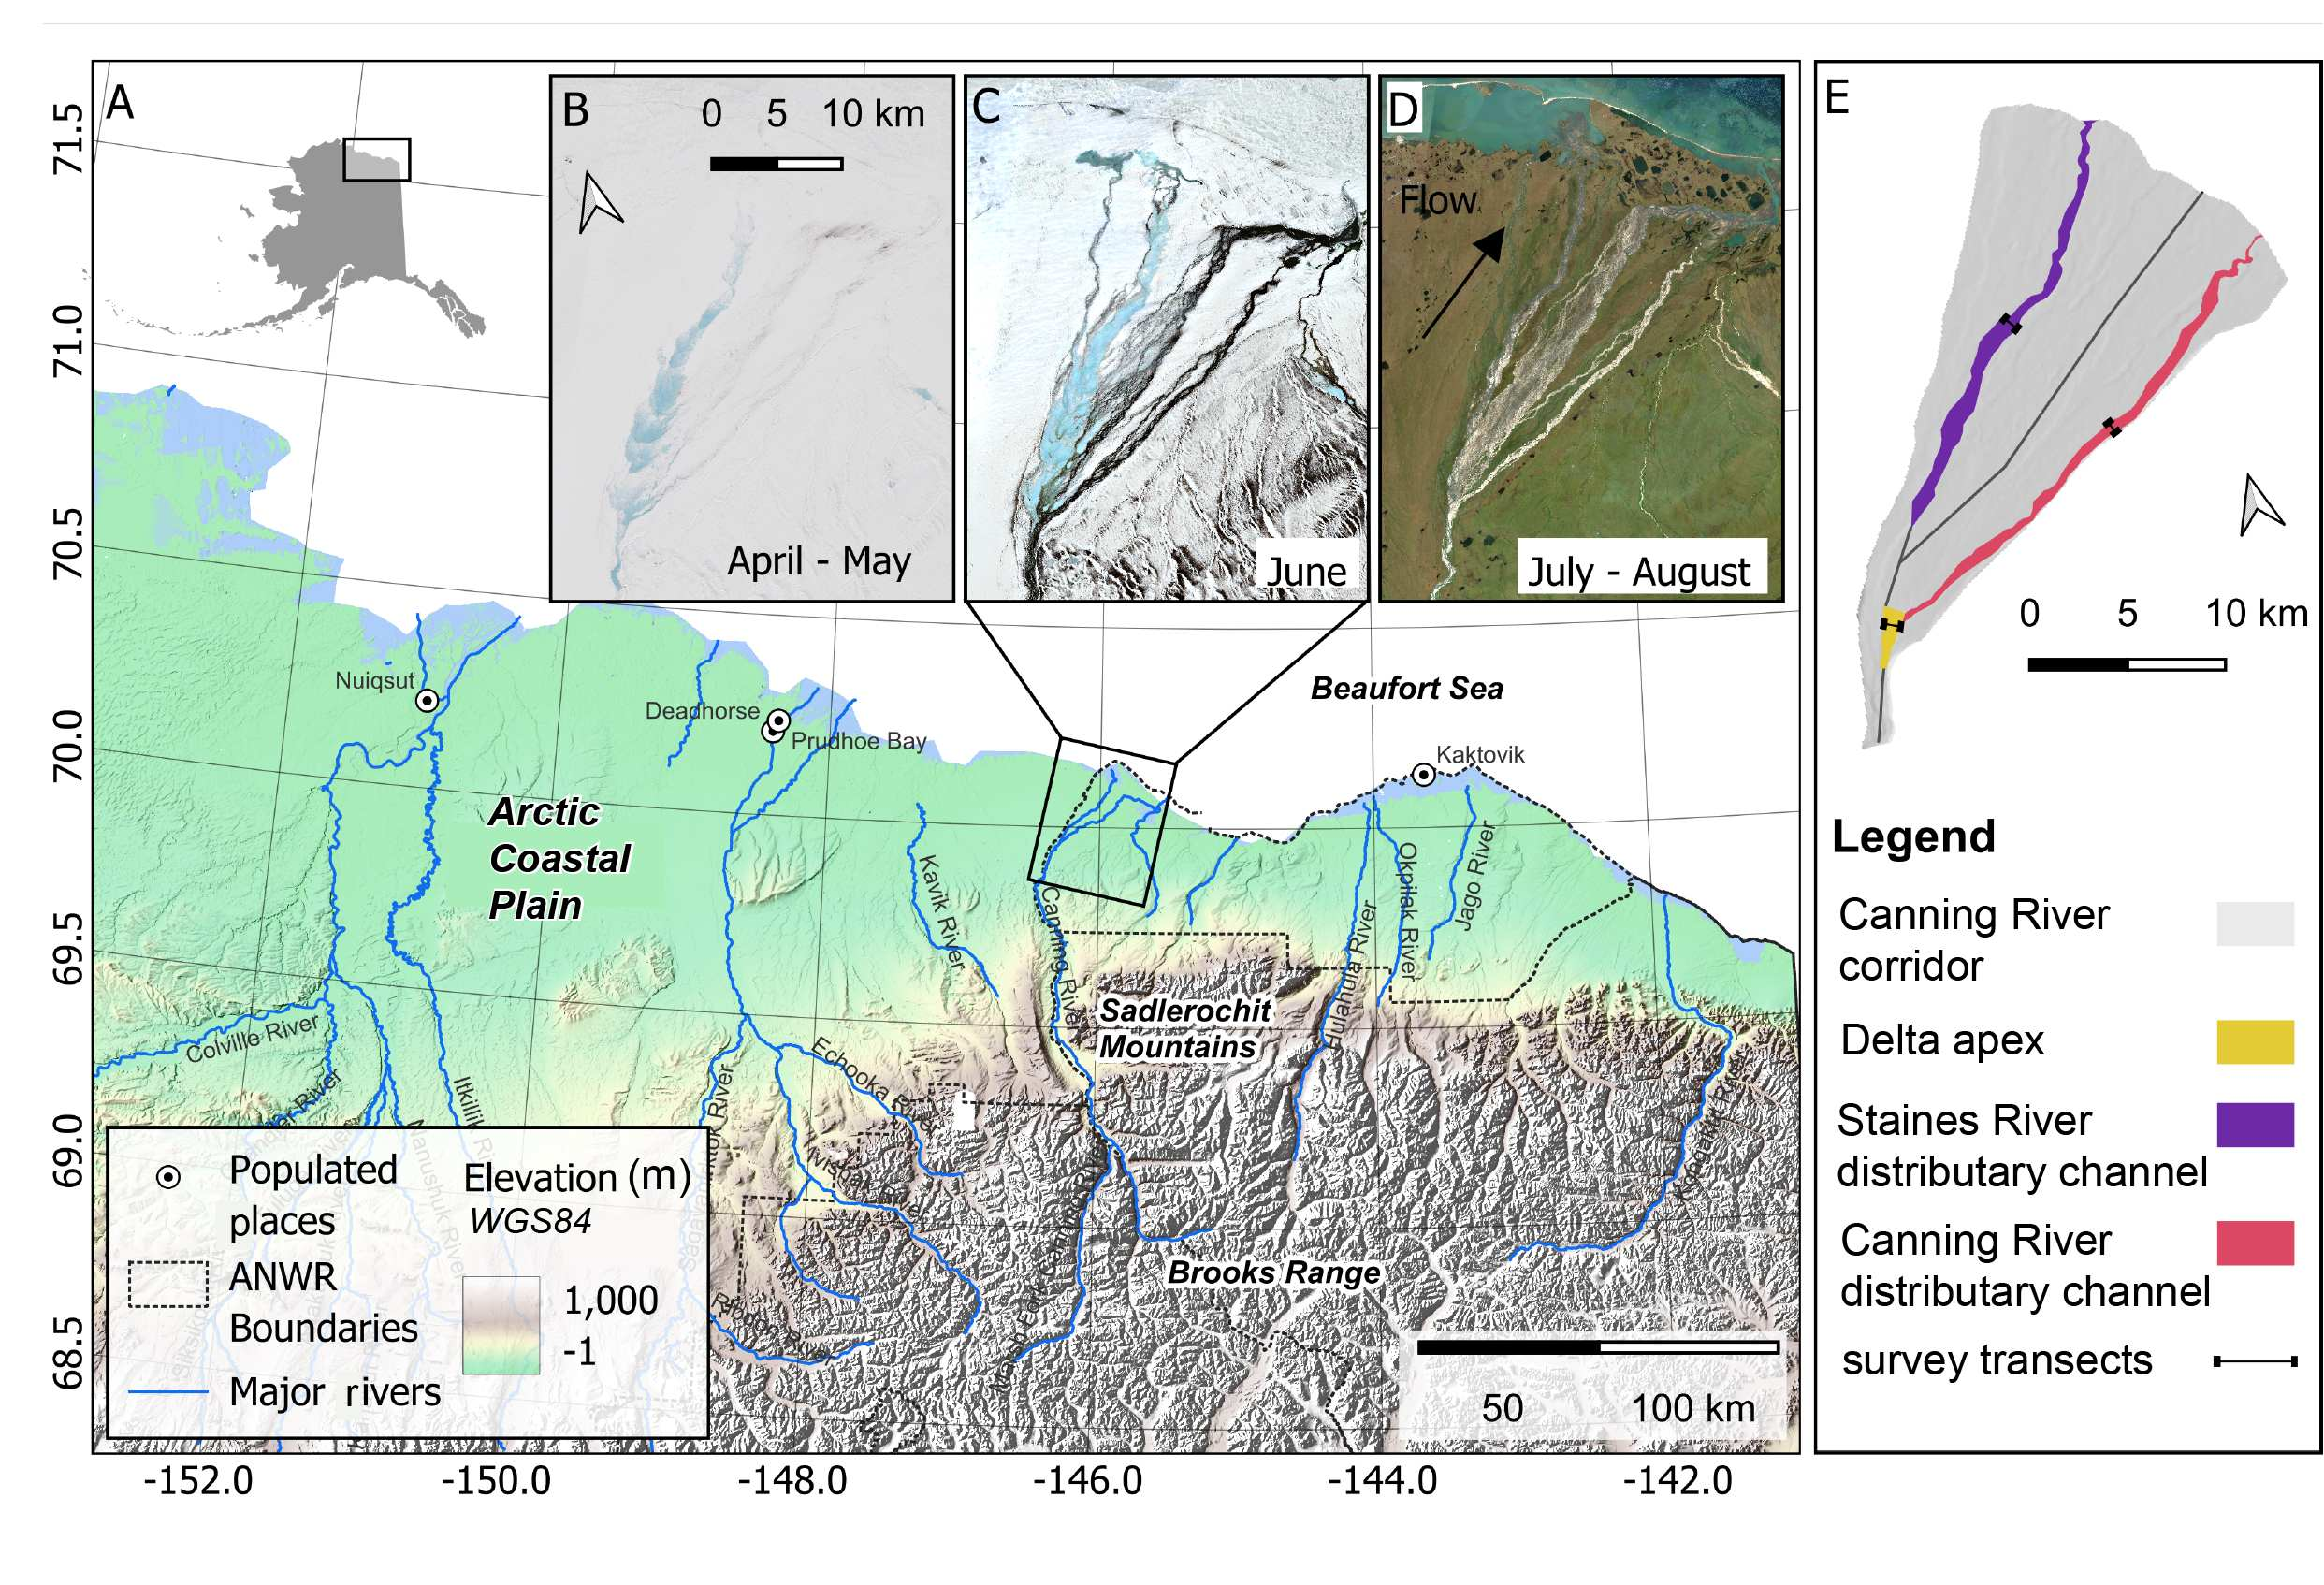

In [6]:
Image(filename = "notebooks/images/figure1_small.jpg", width=800, height=800)

*Figure 1: A: The Canning River’s location in Northeastern Alaska, including geographic landmarks and major rivers (USGS, 2023), and surface elevations from ArcticDEM (Porter et al., 2023). B–D: cloud-free composite images using Sentinel 2-L2A True Color satellite images from 2023 B: April – May 15th composite, C: May 15th -June 15th composite, and D: July-August composite. E: Schematic legend of the Canning River delta and the locations of field surveys. This is Figure 4 in Arcuri et al. (2025), in prep.* 

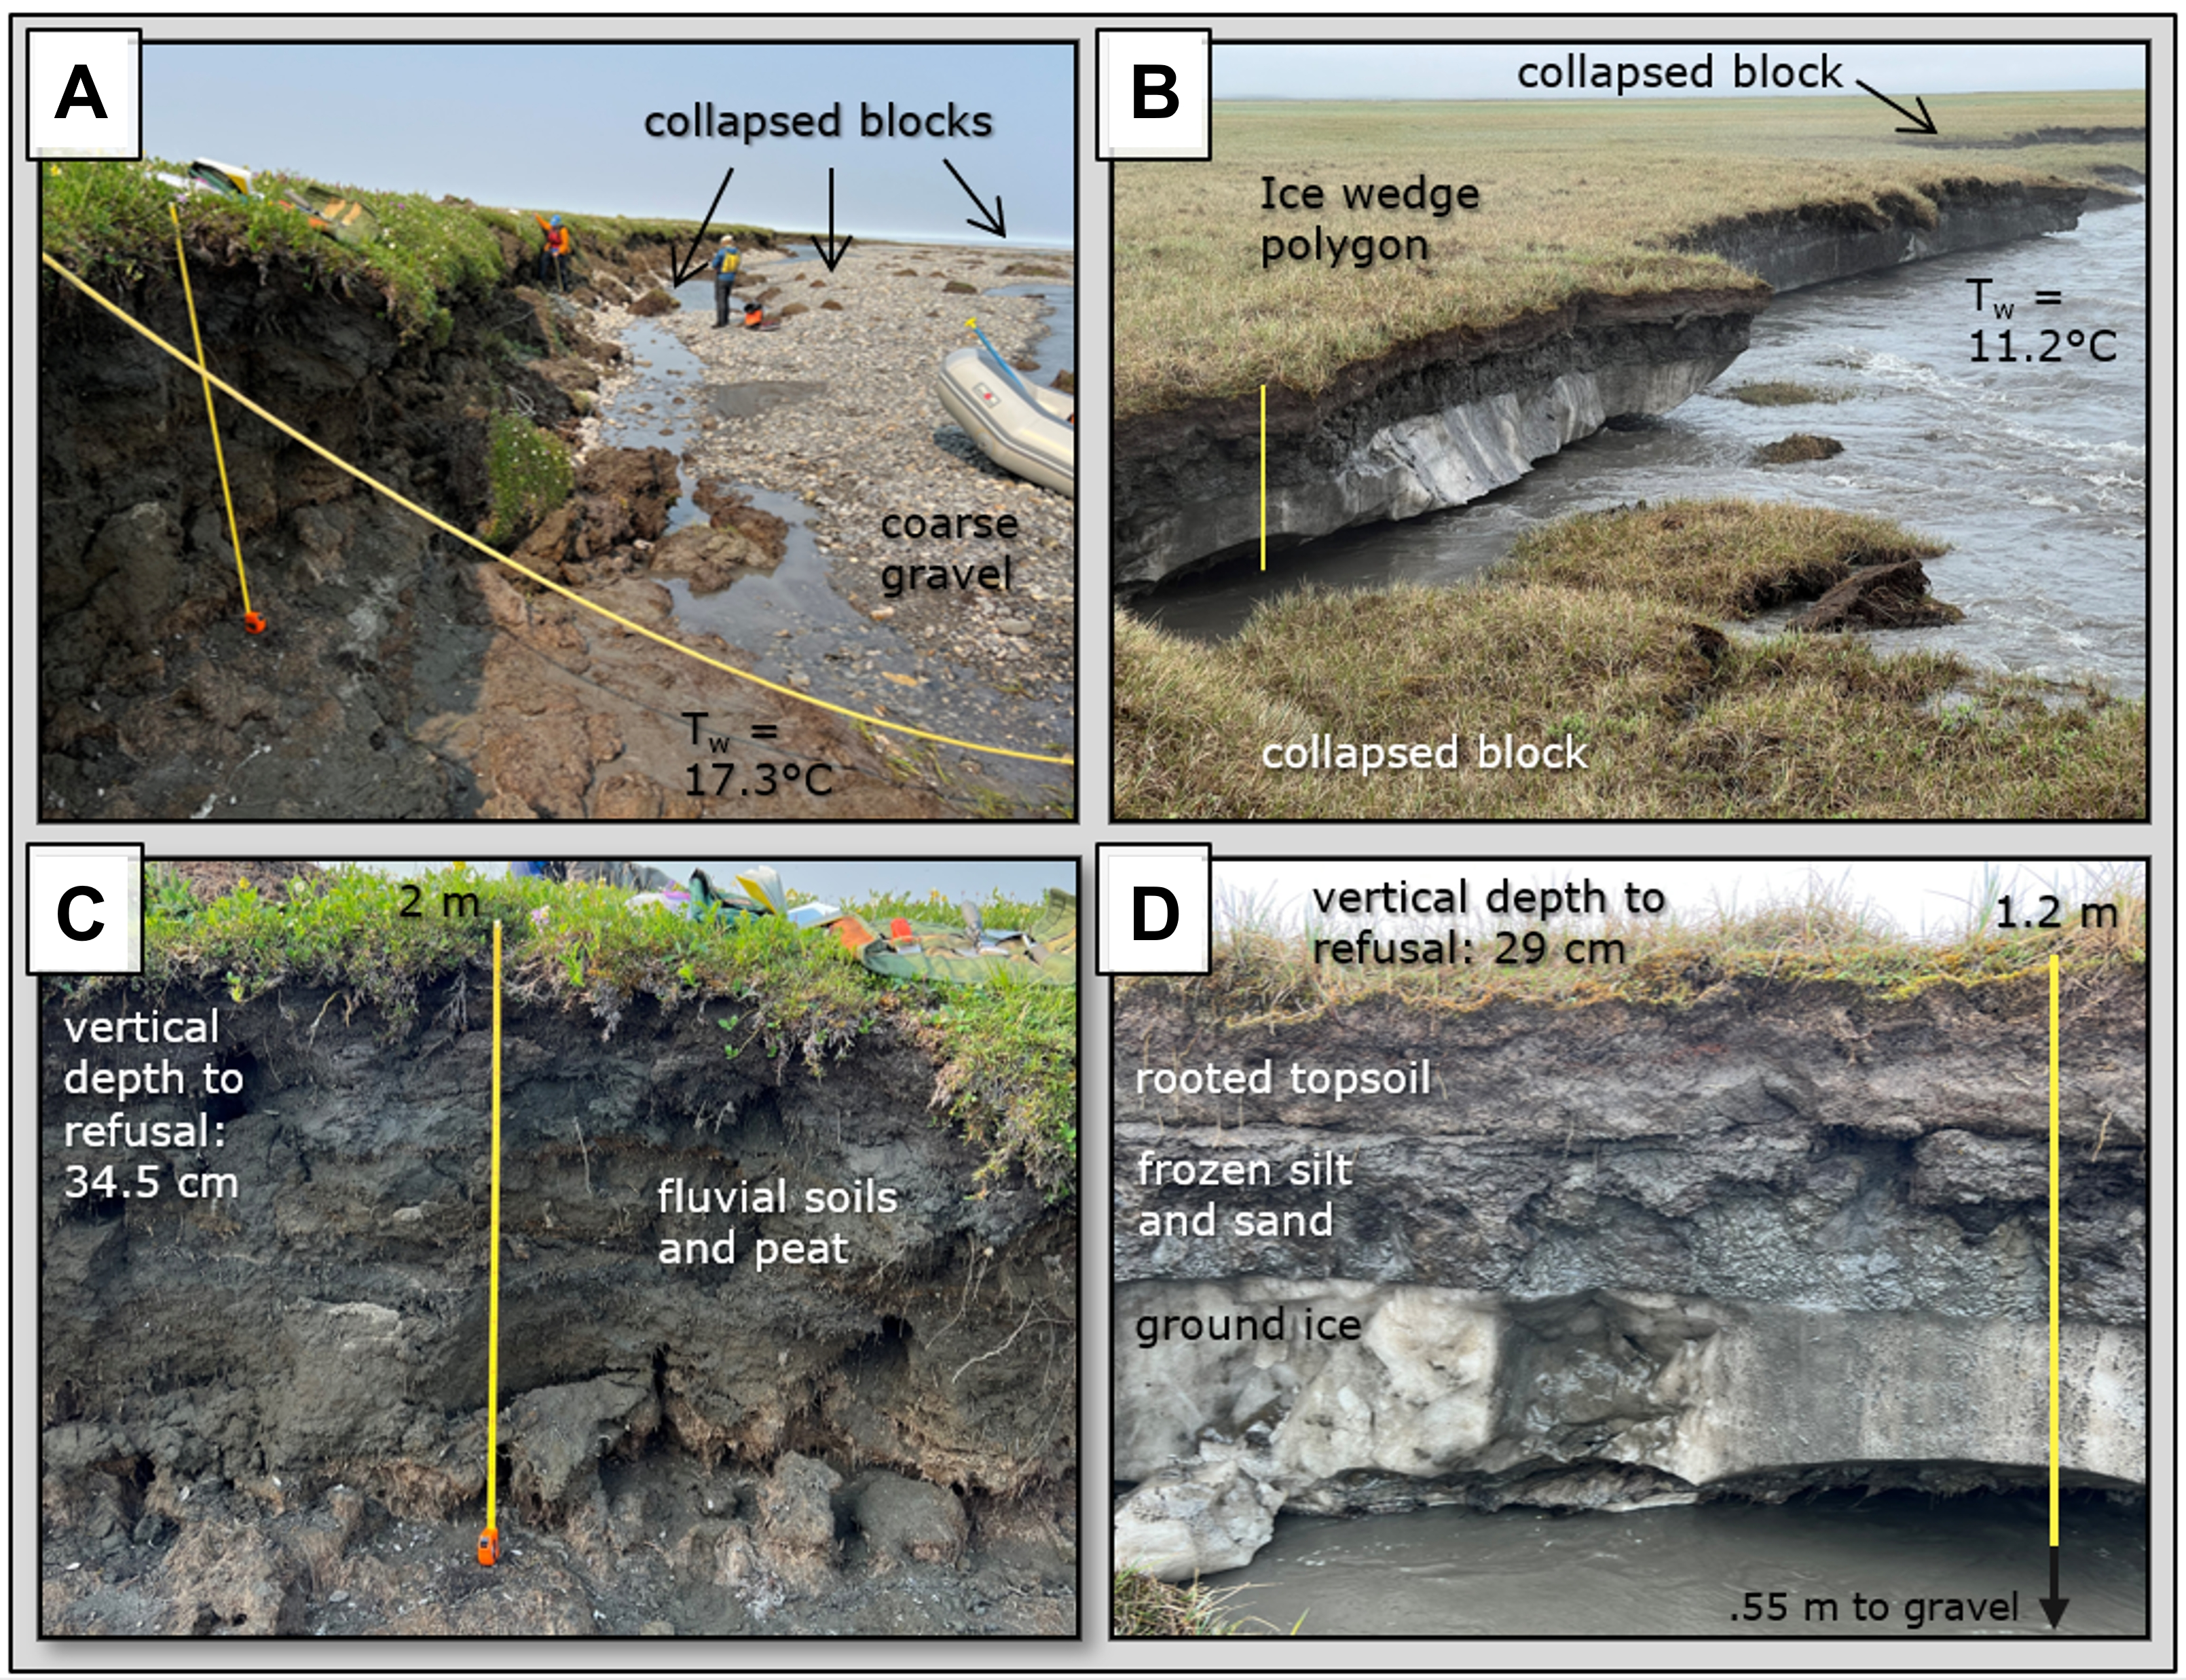

In [7]:
Image(filename = "notebooks/images/figure4_rev.jpg", width=500, height=500)

*Figure 2: Photographs of characteristic river banks at the delta apex (A and C) and the Staines River distributary channel (B and D). Labels indicate stratigraphic features and examples of field measurements. Photograph credit: M. Repasch. This is Figure 4 in Arcuri et al. (2025), in prep.* 

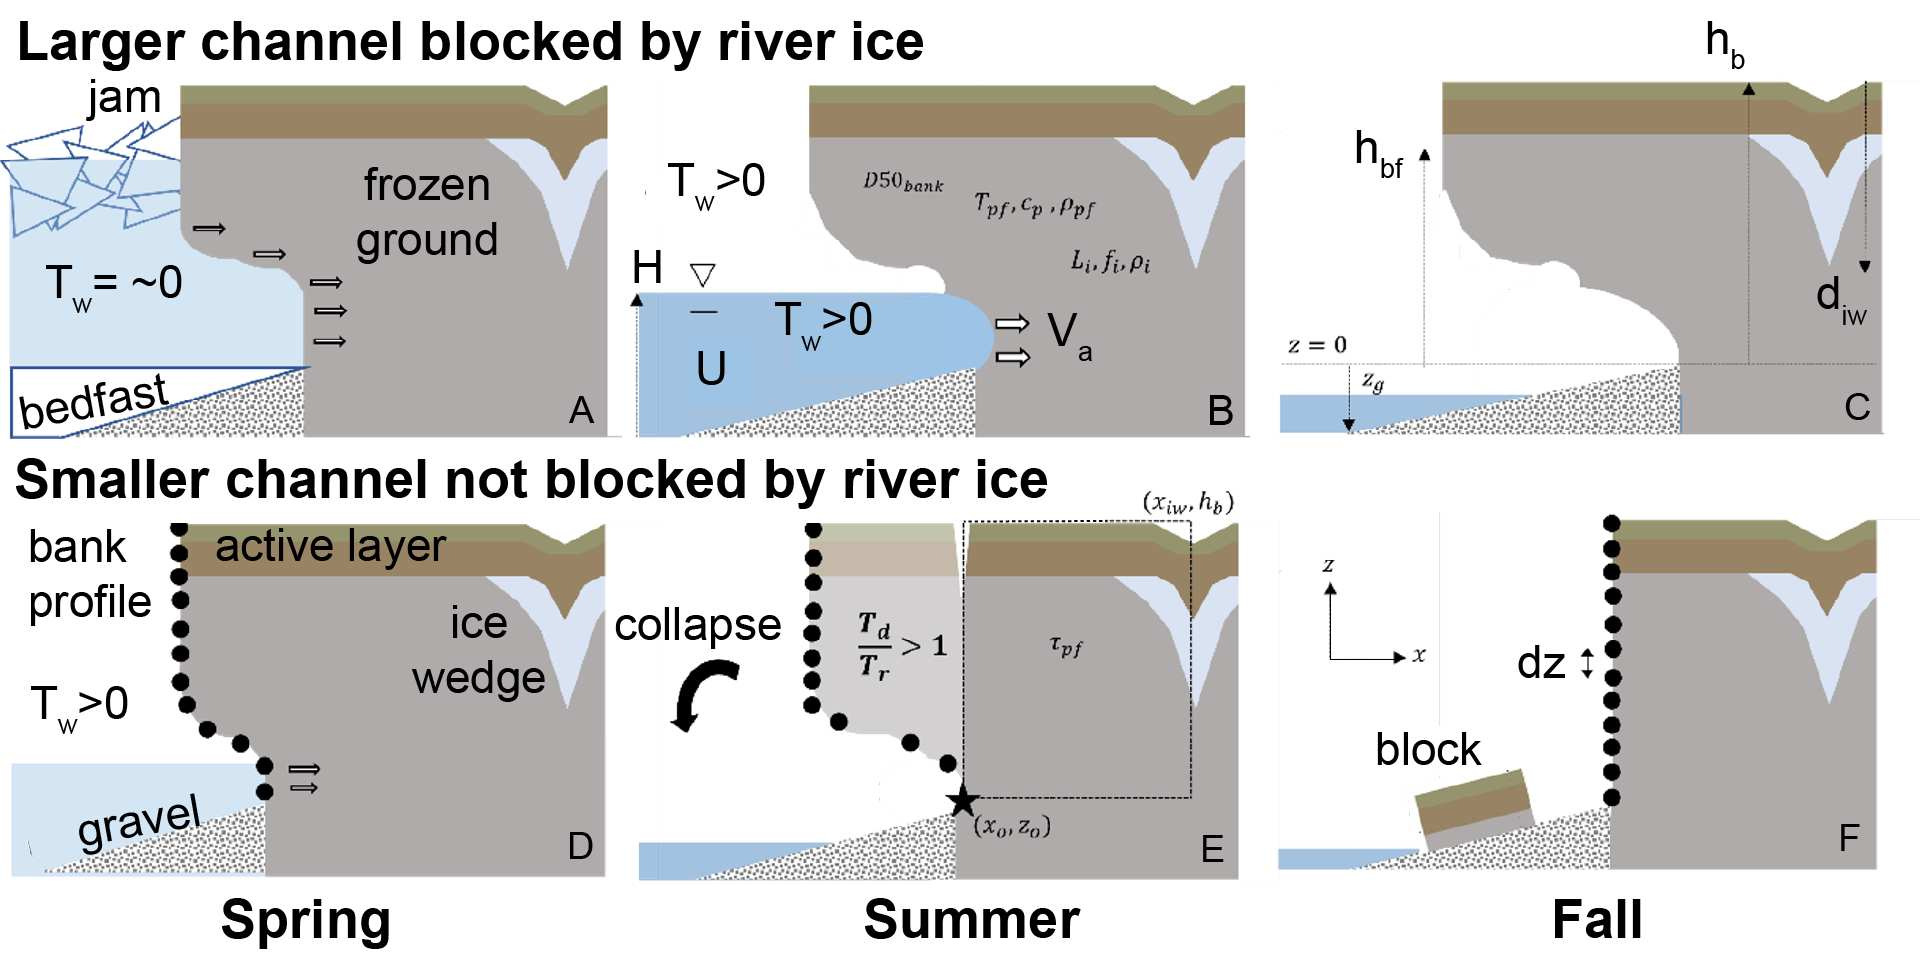

In [10]:
Image(filename = "notebooks/images/Figure7_small.jpg", width=800, height=800)

*Figure 3. A conceptual model for permafrost river bank erosion in an Arctic delta where river ice resists break-up in spring. A: in a large distributary channel, river ice impacts thermal erosion by cooling water but increasing bank exposure to water. White triangles display bedfast river ice conditions during the thermal break-up period. B: following ice break-up, warm river water from summer storms undercuts river banks. C: Undercutting from late-season thermal erosion generates an overhanging block. D: In a smaller distributary channel that does not fill with ice over winter, thermal erosion undercuts banks when they are inundated in spring. E: although banks are infrequently exposed to water in summer, undercutting triggers an upper bank collapse, as the driving torque exceeds the resisting torque. F: banks are relatively stable in fall because thermal erosion is unlikely. Refer to Figure 7 in Arcuri et al. (2025) for variable decriptions.* 

In [ ]:
def get_params():
    """
    define inputs in a dictionary
    
    Return
    ------
    options: dict
        contains all parameters for defining boundary conditions, running the water temperature model, and running the bank erosion model
        
    """
    options = {}

    # Define input directories, this date is used in the accompanying manuscript
    options["dischargedata"] = 'data/primarydata.csv'
    options["metdata"] = 'data/CanningRiverAll_JA.csv'
    options["metdata2"] = 'data/Mfile2.csv'

    # Simulation name
    options['identifier'] = "default"

    # Ablation model "gravelroughness" (Costard et al. 2003) or "bankroughness" (Douglas and Lamb, 2024)
    options['ablationmodel'] = "gravelroughness"  

    # Spacing and timing
    options['dt'] = 60*60*3
    options['dz'] = 0.01
    options['runtime'] =60*60*24*365*2

    ##### River Ice Conditions #####

    # river ice decay starting date,  in days from January 1st
    options['todoy']= 151
    # river ice decay timescale, in days
    options['tau'] = 14
    #day ice starts to accumulate
    options['iceondoy'] = 274 #october 1st 


    ##### River bank material properties #####
    #permafrost temperature
    options["T_permafrost_C"] = -8

    # grain size (84th percentile) of the river bed gravel
    options['D84bed'] = .064
    # grain size (median) of the river bank sediment
    options['D50bank'] = 50e-6

    #height of river bank exposed above gravel bank toe
    options['bh']  = 1.7

    #gravel thickness on river bank toe above the river bed
    options['gravelz'] = .5

    #bankfull river bank height - smallest along the cross section runnign perpendicular to the bank
    options['bfbh']  =   1.6

    #bankfull channel wetted perimeter, width at high stage
    options['width']  = 790

    #ice wedge spacing / distance between troughs on surface, thiis sets the overhanging block dimensions, and how often collapses occur
    options['Xiw'] = 35

    #river bank ice content, in percent of volume, ranging between 40 and 100 %
    options['Fi'] = 75

    #starting river water depth. values below 'starth' are set equal to 'starth', because the river water temperature model is innacurate when flow is shallow. 
    options['starth'] = options['gravelz'] 

    #channel bed slope in m/m
    options['bedslope'] = .003

    #for scenarios without river ice
    options['nullflag'] = False
    return options

In [ ]:
def run_model_scenario(params):
    """
    
    run one model scenario based on input dictionary and gather results in a pandas dataframe
    
        
    Parameters
    ----------
    params: dict
        all inputs for one simulation, uses the default values if empty
    
    Return 
    ----------
    results: Pandas DataFrame
        all inputs for one simulation and the resulting mean annual erosion rate and nondimensional number
    """
        
    # define wiver water stage and meteorological boundary conditions in a dictionary
    BCT= boundaryconditionstools.BoundaryConditionsTools(params)
    bcdict = BCT.get_bcs()

    bcdict= watertemperaturemodel.River_temp_model(bcdict)
    
    # run bank erosion model
    BEM = permabankerosionmodel.BankErosionModel(params, bcdict)
    BEM.run()
    erosionrate = BEM.get_erosion()
    resultsdict = {"meanannualerosionrate_mperyr":erosionrate}
    
    #add parameters and results to pandas dataframe
    df = pd.DataFrame(params|resultsdict, index = [0])
    
    #print and plot results
    fig = BEM.plot_bankprofile(title = str("E = " + str(np.round(erosionrate,2))+ " meters/year"))
    plt.show()

    return df

## Run with default parameters

In [ ]:
params = get_params()

In [ ]:
results = run_model_scenario(params)

## Run without river ice
#### Use same default inputs, but change ice decay timing and set "nullflag" to False so that ice does not impact hydrodynamics or water temperature


In [ ]:
params_noice = get_params()


params_noice["tau"] = 0
params_noice["nullflag"] = True

results_noice= run_model_scenario(params_noice)

## Run with different ablation model

In [ ]:
params_model2 = get_params()
#use same default inputs as in original simulation, but change the ablation model

params_model2["ablationmodel"] = "bankroughness"
results_model2= run_model_scenario(params_model2)

## Save results

In [ ]:
allresults = pd.concat((results, results_noice,results_model2))

In [ ]:
allresults.to_csv("outputs/demo_results.csv") 

## References

Arcuri, J., Overeem, I., Repasch, M., Anderson, S.P., Anderson, R.S., Koch, J. Urban, F. (2025) *in review*.

Barnhart, K.R., Anderson, R.S., Overeem, I., Wobus, C., Clow, G.D. and Urban, F. (2013) ‘Modeling erosion of ice-rich permafrost bluffs along the Alaskan Beaufort Sea coast’, Journal of Geophysical Research F: Earth Surface, 119(5), pp. 1155–1179. Available from: https://doi.org/10.1002/2013JF002845.

Costard, F., Dupeyrat, L., Gautier, E. and Carey‐Gailhardis, E., 2003. ‘Fluvial thermal erosion investigations along a rapidly eroding river bank: application to the Lena River (central Siberia)’. Earth Surface Processes and Landforms, 28(12), pp.1349-1359. Available from: https://doi.org/10.1002/esp.592.

Douglas, M.M. and Lamb, M.P. (2024) ‘A Model for Thaw and Erosion of Permafrost Riverbanks’, Journal of Geophysical Research: Earth Surface, 129(4), p. e2023JF007452. Available from: https://doi.org/10.1029/2023jf007098. 

Prowse, T.D. and Beltaos, S. (2002) ‘Climatic control of river-ice hydrology: A review’, Hydrological Processes, 16(4), pp. 805–822. Available from: https://doi.org/10.1002/HYP.369.

Zheng, L., Overeem, I., Wang, K. and Clow, G.D. (2019). Changing Arctic river dynamics cause localized permafrost thaw. Journal of Geophysical Research: Earth Surface, 124(9), pp.2324-2344. Available from: https://doi.org/10.1029/2019JF005060.



## Data

U.S.Geological Survey (20232021). USGS water data for the Nation. US Geological Survey National Water Information System database. Available at: https://waterdata.usgs.gov/nwis [Accessed: June 30, 2023, at https://doi.org/10.5066/F7P55KJN.